In [1]:
# guide to generate CHM from lastools.
# http://wiki.awf.forst.uni-goettingen.de/wiki/index.php/Canopy_Height_Model_based_on_Airborne_Laserscanning_using_LAStools
# 
# get all sites 
import glob
# Define the path
path = '/gpfs/data1/vclgp/data/gedi/imported/*/*/'
# Get folder names
folder_names = glob.glob(path)
print(len(folder_names))
# Filter out folders containing 'clipped'
folder_sites = [n for n in folder_names if 'clipped' not in n]
print("Total als site names:", len(folder_sites))
print("Example folder name:", folder_sites[1])

3650
Total als site names: 511
Example folder name: /gpfs/data1/vclgp/data/gedi/imported/asia/nagano_japan_full/


In [28]:
# example site 
all_laz = glob.glob('/gpfs/data1/vclgp/data/gedi/imported/usa/plumasnf_20180707/LAZ_ground/*.laz')
all_laz[3]

'/gpfs/data1/vclgp/data/gedi/imported/usa/plumasnf_20180707/LAZ_ground/plumasnf_20180707_-108000_191000_seamless_0000000.laz'

In [29]:
# laz to las file 
# 
import os
laz_path = all_laz[3]
region = laz_path.split('/')[7]
name = laz_path.split('/')[8]
las_out = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las/' + region + '/' + name

In [6]:
os.system(f'wine $LASTOOLS/las2las.exe -i {laz_path} -odir {las_out} -olas')

'/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las/usa/plumasnf_20180707'

In [30]:
norm_out = las_out.replace('/las/', '/las_norm/')
norm_out

'/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las_norm/usa/plumasnf_20180707'

In [10]:
os.makedirs(norm_out, exist_ok=True)

In [12]:
os.system(f'wine $LASTOOLS/lasheight.exe -drop_above 150 -drop_below -3  -replace_z -i {las_out}/*.las -odir {norm_out} -olaz')

done with '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las_norm/usa/plumasnf_20180707\plumasnf_20180707_-52000_198000_seamless_0000000.laz'. total time 23.352 sec.


0

In [31]:
# direclty read 
os.system(f'wine $LASTOOLS/lasheight.exe -drop_above 150 -drop_below -3  -replace_z -i {all_laz[3]} -odir {norm_out} -olaz -v')

first pass. reading 10276461 points to count ground points ... 
took 4.636 sec. counted 2539352 ground points.
second pass. triangulating 2539352 ground points ...
took 8.863 sec. triangulated 2539352 points.
third pass. computing heights for 7737109 points ...
dropped 26  of 10276461 points
done with '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las_norm/usa/plumasnf_20180707\plumasnf_20180707_-108000_191000_seamless_0000000.laz'. total time 28.562 sec.


0

In [13]:
chm_path = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result_chm/' + region + '/' + name
os.makedirs(chm_path, exist_ok=True)

In [32]:
# get dem 
os.system(f'wine $LASTOOLS/blast2dem.exe  -i {norm_out}/*.laz -odir {chm_path} -otif ')

duplicate_points 19285
duplicate_points 24659


0

In [139]:
# plot chm
tif= glob.glob(chm_path+ '/*.tif')
print(len(tif))

13182


In [143]:
# remove bad tifs. 
bad = []
for t in tif:
    size_in_bytes = os.path.getsize(t)
    # Convert bytes to kilobytes
    size_in_kb  = size_in_bytes / 1024
    if size_in_kb < 1:
        #print(t)
        bad.append(t)
        os.remove(t)

In [142]:
print(len(bad))
bad[1]

2295


'/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result_chm/usa/plumasnf_20180707/plumasnf_20180707_-28000_205000_seamless_0000002.tif'

file /gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/chm_v1/plumasnf_20180707_wgs84.tif, p5 0.0 , p95 20.364999294281006


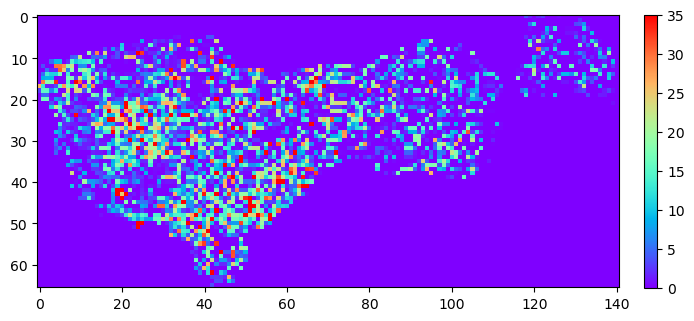

In [153]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
c= tif[2010]
c= '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/chm_v1/plumasnf_20180707_wgs84.tif'
dataset = rasterio.open(c)
band1 = dataset.read(1)
data = band1[~np.isnan(band1)]
data = data[data != -9999]
if len(data) < 1: 
    print('No data in this file', c)
p5 = np.percentile(data, 5)
p95 = np.percentile(data, 95)
print(f'file {c}, p5 {p5} , p95 {p95}')
plt.figure(figsize=(8, 4))  # Adjust the width and height as desired
plt.imshow(band1, cmap='rainbow' , vmin = 0, vmax = 35)
cbar = plt.colorbar(fraction=0.022, pad=0.04)
plt.show()

# get 1km tiles list

In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In [4]:
gdf = geopandas.read_parquet('../data/all_sites_20240703.parquet')
print(gdf)

       region           name     area_ha   epsg  \
0         usa        usda_me   39.509840  26919   
1         usa        usda_me   74.565161  26919   
2         usa        usda_me   33.698329  26919   
3         usa        usda_me   59.362166  26919   
4         usa        usda_me   25.889235  26919   
...       ...            ...         ...    ...   
353703    usa  neon_niwo2019  919.415684  32613   
353704    usa  neon_niwo2019  195.803013  32613   
353705    usa  neon_niwo2019   12.865431  32613   
353706    usa  neon_niwo2019  790.140257  32613   
353707    usa  neon_niwo2019  358.981628  32613   

                                                 geometry  \
0       POLYGON ((-69.91152 46.61153, -69.90748 46.611...   
1       POLYGON ((-69.25080 46.05870, -69.24307 46.058...   
2       POLYGON ((-69.38241 46.02053, -69.37891 46.020...   
3       POLYGON ((-69.31656 45.60490, -69.31036 45.604...   
4       POLYGON ((-70.22245 45.79862, -70.21976 45.798...   
...                  

In [28]:
ls ../result/ease1km_tile/southamerica/inpe_brazil31973/

chm_1km/  classified/  laz_1km/  laz_500m/  norm/  thin/  tile_gpkg/


In [7]:
import rioxarray

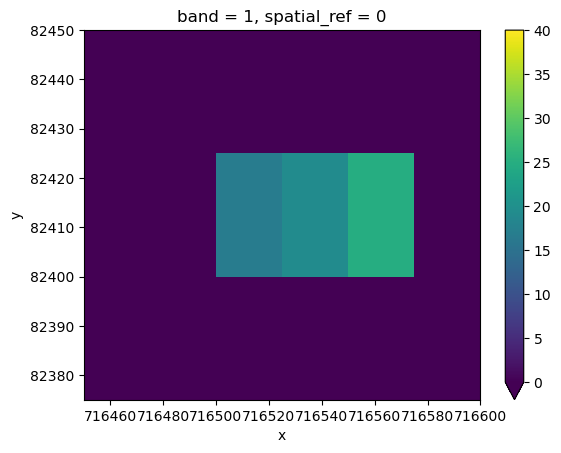

In [27]:
xds = rioxarray.open_rasterio('../result/ease1km_tile/southamerica/inpe_brazil31973/chm_1km/X10888Y07214.tif')
xds[0].plot(vmin=0, vmax=40)

In [34]:
df  =  xds[0].to_dataframe(name = 'h_als')

In [35]:
df

band  spatial_ref        h_als
y       x                                       
82437.5 716462.5     1            0 -9999.000000
        716487.5     1            0 -9999.000000
        716512.5     1            0 -9999.000000
        716537.5     1            0 -9999.000000
        716562.5     1            0 -9999.000000
        716587.5     1            0 -9999.000000
82412.5 716462.5     1            0 -9999.000000
        716487.5     1            0 -9999.000000
        716512.5     1            0    16.690001
        716537.5     1            0    19.170000
        716562.5     1            0    24.760000
        716587.5     1            0 -9999.000000
82387.5 716462.5     1            0 -9999.000000
        716487.5     1            0 -9999.000000
        716512.5     1            0 -9999.000000
        716537.5     1            0 -9999.000000
        716562.5     1            0 -9999.000000
        716587.5     1            0 -9999.000000

In [37]:
df[(df != -9999).all(axis=1)].mean()

band            1.000000
spatial_ref     0.000000
h_als          20.206667
dtype: float64

# optimize code for chms 

In [69]:
ls -lh ../result/ease1km_tile/africa/jpl_rabi/thin/ | wc -l

118


In [80]:
import glob
chms = glob.glob('/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/ease1km_tile/usa/neon_yell2020/chm_1km/*.tif')

In [81]:
len(chms)

293

In [82]:
import numpy as np
result_1d = np.full(len(chms), -999, dtype=np.float32)

In [83]:
for index, chm in enumerate(chms):
    try:
        xds = rioxarray.open_rasterio(chm)
    except:
        continue
    df = xds[0].to_dataframe(name = 'h_als')
    df_cleaned = df[~(df == -9999).any(axis=1)]
    value = df_cleaned['h_als'].mean()
    result_1d[index] = np.array([value])

In [85]:
np.mean(result_1d)

nan

In [88]:
## update
cleaned_arr = result_1d[~np.isnan(result_1d)]
np.mean(cleaned_arr)

2.282442

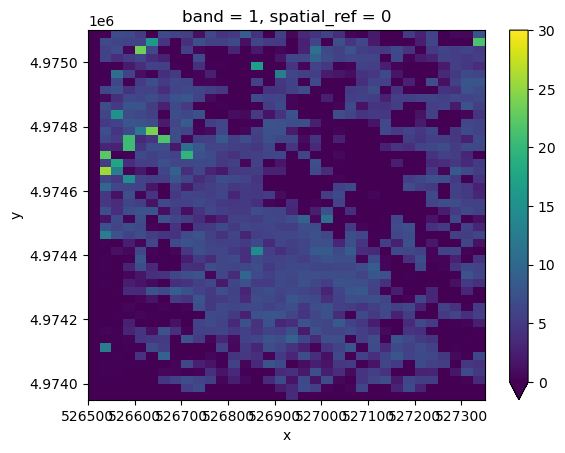

In [106]:
xds = rioxarray.open_rasterio(chms[10])
xds[0].plot(vmin=0, vmax=30)